In [1]:
#General
import numpy as np
from numpy import nanmin, nanmax, nanmean, nanmedian
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord, match_coordinates_sky
import pandas as pd
from parse import *
import requests
import os
import wget
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO

In [2]:
#Helper functions
def check_ra_dec_in_bounds(ra,dec,ra_min,ra_max,dec_min,dec_max, image_size_deg = 1., return_edge_distances = True):
    if ra_min > ra_max:
        ra_min -= 360.
    if ra > 360.-image_size_deg: #Handle wraps at 359 - 1 deg
        ra -= 360. 
    if ra_min < ra < ra_max:
        if dec_min < dec < dec_max:
            dist = np.min([np.abs(x) for x in [ra_min-ra, ra_max-ra, dec_min-dec, dec_max-dec]])*u.deg.to(u.arcsec)
            if return_edge_distances:
                return True, dist
            else:
                return True      
    if return_edge_distances:
        dist = np.min([np.abs(x) for x in [ra_min-ra, ra_max-ra, dec_min-dec, dec_max-dec]])*u.deg.to(u.arcsec)
        return False, dist
    else:
        return False

def open_image_and_get_WCS(img):
    data = fits.getdata(img)
    header = fits.getheader(img)
    w = WCS(header)
    return w, data, header

def get_box(x,y, s):
    '''Input x, y coordinates, sidelength radius s. (x,y) can be float, s is an integer (e.g. 1, 3, 5 for a 1x1, 3x3, 5x5). Returns array of coordinates in a box of sidelength s around x,y'''
    radius = (s-1)/2
    xnearest = int(round(float(x)))
    ynearest = int(round(float(y)))
    xmin = xnearest-radius
    xmax = xnearest+radius+1
    ymin = ynearest-radius
    ymax = ynearest+radius+1
    return [xmin, xmax, ymin, ymax]


# Legacy functions
def get_legacy_sky_image(ra, dec, size=256):
    url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&layer=ls-dr10&size={size}"
    r = requests.get(url)
    return Image.open(BytesIO(r.content))

def get_unwise_image (ra, dec, size=256):
    url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&layer=unwise-neo7&size={size}"
    r = requests.get(url)
    return Image.open(BytesIO(r.content))


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    '''Get URL for images in the table
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    '''
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url

# def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    """
    Get color image at a sky position from the Legacy Survey.
    ra, dec = position in degrees
    size = extracted image size in pixels (default 240).
    output_size = ignored (for compatibility with original signature)
    filters = ignored (used in PanSTARRS, not here)
    format = "jpg" or "png"
    Returns a PIL image.
    """
#    if format not in ("jpg", "png"):
#        raise ValueError("format must be jpg or png")
#    if format == "png":
#        print("Warning: Legacy Survey only provides JPG images — returning JPG")
#    url = f"https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra}&dec={dec}&layer=ls-dr10&size={size}"
#    r = requests.get(url)
#    im = Image.open(BytesIO(r.content))
#    return im

#def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    """Get grayscale image at a sky position
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
#    if format not in ("jpg","png"):
#        raise ValueError("format must be jpg or png")
#    if filter not in list("grizy"):
#        raise ValueError("filter must be one of grizy")
#    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
#    r = requests.get(url[0])
#    im = Image.open(BytesIO(r.content))
#    return im

In [3]:
#Main functions
def get_image_list(ra, dec, unit, metadata, names = None, ncheck = 10, min_edge_distance_arcsec = 5, verbose = False):
    '''
    Required input: 
    - ra, dec (can be array)
    - metadata (pandas table, read from VLASS_image_metadata_{date}.csv)
    Optional input:
    - name(s) (can be array, must be same length as ra, dec)
    Output: 
    - image_dict: dictionary of all images containing ra, dec within bounds and their edge distances
    Options:
    - ncheck = number of images to check per coordinate
    - min_edge_distance_arcsec = minimum distance from the edge of the image in arcsec
    '''
    if type(ra) == float:
        ra = [ra]
        dec = [dec]
    if names == None:
        names = ['Coord_'+str(i) for i in range(len(ra))]
    ra = np.array(ra)
    dec = np.array(dec)
    names = list(names)
    target_coords = SkyCoord(ra = ra, dec = dec, unit = unit)
    ra_deg, dec_deg = target_coords.ra.deg, target_coords.dec.deg
    meta_cat = SkyCoord(ra = np.array(metadata['central_ra'])*u.deg, dec = np.array(metadata['central_dec'])*u.deg)
    output = {}
    for n in range(ncheck):
        idx,d2d,d3d = match_coordinates_sky(target_coords, meta_cat, nthneighbor=n+1, storekdtree='tree')
        ra_min, ra_max, dec_min, dec_max, imagenames = [np.array(metadata.iloc[idx][x]) for x in ['ra_min','ra_max','dec_min','dec_max','Imagename']]
        for i, name in enumerate(names):
            try:
                output[name]
            except Exception as e:
                if verbose:
                    print(e)
                output[name] = {}
                output[name]['images'] = []
                output[name]['edge_distance_arcsec'] = []
            ra_i, dec_i = ra_deg[i], dec_deg[i]
            ra_min_ni, ra_max_ni, dec_min_ni, dec_max_ni = [arr[i] for arr in [ra_min, ra_max, dec_min, dec_max]]
            contained, edge_dist = check_ra_dec_in_bounds(ra_i,dec_i,ra_min_ni,ra_max_ni,dec_min_ni,dec_max_ni)
            if contained:
                if edge_dist > min_edge_distance_arcsec:
                    output[name]['images'].append(imagenames[i])
                    output[name]['edge_distance_arcsec'].append(edge_dist)
    return output
            
def download_image(image, outdir = None, name = None, verbose = False):
    '''
    Required input:
    - image (e.g., from output of get_image_list(). One image per function call.)
    Optional input:
    - outdir (directory to download image to. Default is current directory.)
    - name (user specified name of output image)
    - verbose (prints when downloads are attempted and whether they succeeded)
    Output:
    - Downloads image, returns path to image
    '''
    if outdir is None:
        outdir = os.getcwd()+'/'
    if name is None:
        name = image
    try:
        #'VLASS1.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'
        epoch, tile, _ = parse('{}.ql.{}.{}',image)
        dirname, _ = parse('{}.I.{}',image)
        if '1.' in epoch:
            epoch += 'v2'           
        url = '/'.join(['https://archive-new.nrao.edu/vlass/se_continuum_imaging/',epoch,tile,dirname,image])
        #print(url)
        if os.path.isfile(outdir+name):
            if verbose:
                print('Skipping already downloaded file: ', name)
            pass
        else:
            if verbose:
                print('Downloading: ', name)
            dl = wget.download(url,out=outdir)
            print()
            print('Successfully downloaded: ', name)
            return outdir+name
    except Exception as e:
        print(e)
        return 

def make_cutout(ra,dec,unit,images,metadata, \
                calculate_stats = True, cutout_size = 61, stats_box_size = 15,\
                show = False, save = False, outdir = None, name = None, cmap = 'inferno',\
                normalization = 'linear', normalization_params = {'vmin':-0.5e-3,'vmax':1e-3}, show_circle = True, \
                panstarrs = False, overwrite = False, verbose = False):
    '''
    Required Input: 
    - ra, dec
    - unit (unit of ra, dec)
    - images (array of images corresponding to ra, dec. Must be full path.)
    - metadata (same as in get_image_list61.18744309)
    Optional Input:
    - calculate_stats (calculate basic summary statistics of image cutout T/F)
    - cutout_size (sidelength of image in pixels. 1 pixel = 1 arcsec)
    - stats_box_size (sidelength of box in which to calculate stats. 1 pixel = 1 arcsec)
    - show (show created images T/F)
    - save (save file T/F)
    - outdir (output directory for image cutouts)
    - name (user specified name. required if save = True)
    - cmap (matplotlib colormap, defaults to inferno)
    - normalization (renormalize colorscale)
    - normalization_params (parameters for normalization. Currently only linear supported, defaults to min value -0.5mJy, max 1mJy)
    - show_circle (show circle at ra, dec)
    - panstarrs (download panstarrs image T/F)
    - overwrite (T/F overwrite previous image if it exists)
    - verbose
    Outputs:
    - returns arrays of pixel values from image cutouts
    - if save = True, creates png cutout in outdir
    '''
    if show == False and save == False and calculate_stats == False:
        print('No operations requested')
        return
    #Setup
    c = SkyCoord(ra = ra, dec = dec, unit = unit)
    ra = c.ra.deg
    dec = c.dec.deg
    if name == None:
        name = 'cutout_'+c.to_string('hmsdms', sep = ':', precision = 1)
    if show or save:
        buffer = 0
        if panstarrs:
            buffer += 2
        figsize = (5*len(images)+buffer,6)
        fig, axes = plt.subplots(ncols = len(images) + buffer, figsize = figsize)
    #Get cutouts and add to figure
    max_pixs = []
    center = (cutout_size-1)/2
    box_data = None
    for i, img in enumerate(images):
        if verbose: print('Attempting cutout for: ', img)
        try:
            #Read in full image
            data = fits.getdata(img)
            imsize = np.shape(data)[-1]+1
            f = fits.open(img)
            w = WCS(f[0].header)
            xpix, ypix, _, _ = w.wcs_world2pix(ra, dec, 3000000000.0, 1.0, 0)
            #Get stat box data, calculate stats
            if calculate_stats:
                xmin_stat, xmax_stat, ymin_stat, ymax_stat = [int(x) for x in get_box(xpix, ypix, stats_box_size)]
                #Handle cases around image edge
                xmin_stat, ymin_stat = [np.max([0,xmin_stat]),np.max([0,ymin_stat])]
                xmax_stat, ymax_stat = [np.min([xmax_stat,imsize]),np.min([ymax_stat,imsize])]
                stat_box_data = data[0][0][ymin_stat:ymax_stat,xmin_stat:xmax_stat]
                stat_max = np.max(stat_box_data)
                max_pixs.append(stat_max)
            #Make image cutout
            if show or save:
                ax = axes[i]
                ax.axis('off')
                xmin, xmax, ymin, ymax = [int(x) for x in get_box(xpix, ypix, cutout_size)]
                xmin,ymin = [np.max([0,xmin]),np.max([0,ymin])]
                xmax,ymax = [np.min([xmax,imsize]),np.min([ymax,imsize])]
                box_data = data[0][0][ymin:ymax,xmin:xmax]
                if calculate_stats:
                    p16,p50,p84 = [x*1000 for x in np.percentile(box_data,[16,50,84])]
                    plus_err = f"{p84 - p50:.5f}"
                    minus_err = f"{p50 - p16:.5f}"
                    p50_str = f"{p50:.5f}"
                if normalization == 'linear':
                    vmin, vmax = normalization_params['vmin'], normalization_params['vmax']
                    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
                    ax.imshow(box_data, cmap = cmap, norm = norm, origin = 'lower')
                else:
                    ax.imshow(box_data, cmap = cmap, origin = 'lower')
                epoch, _ = parse('{}.ql{}',img)
                timestamp = metadata[metadata['Imagename'] == img]['Obs-time'].iloc[0]
                subtitle_str = f"{epoch}\n{timestamp}"
                if calculate_stats:
                    subtitle_str += f"\nMax (mJy) = {round(stat_max * 1000, 5)}"
                ax.set_title(subtitle_str)
                if show_circle:
                    center_x = xpix - xmin
                    center_y = ypix - ymin
                    ax.scatter(center_x, center_y, color = 'none', edgecolor ='blue', s = 500)
        except Exception as e:
            if verbose: print(e)
    if panstarrs:
        #Legacy Survey image
        ax = axes[len(images)]
        ax.axis('off')
        cim = get_legacy_sky_image(ra, dec, size=(cutout_size-1)*4)
        ax.imshow(cim)
        ax.set_title('Legacy Survey (DS10)')
        if show_circle == True:
            ax.scatter(center*4, center*4, color = 'none', edgecolor ='blue', s = 500)
        # unWISE Survey image
        ax_unwise = axes[len(images) + 1]
        ax_unwise.axis('off')
        unwise_img = get_unwise_image(ra, dec, size=(cutout_size-1)*4)
        ax_unwise.imshow(unwise_img)
        ax_unwise.set_title('unWISE Survey (NEO7)')
        if show_circle:
            ax_unwise.scatter(center*4, center*4, color='none', edgecolor='blue', s=500)
    if calculate_stats:
        title_str = name + '\n'  \
        + c.to_string('hmsdms',sep=':',precision = 3) + '\n'\
        'max pix (mJy): '+'    '.join([str(round(x,3)) for x in np.array(max_pixs)*1000]) 
    else:
        title_str = name + '\n' + c.to_string('hmsdms',sep=':',precision = 3)
    # plt.suptitle(title_str)
    plt.tight_layout()
    fig.suptitle(title_str, fontsize=14, y=1.05)
    #Save png
    if save:
        if outdir is None:
            outdir = os.path.join(os.getcwd(), "Data/")
        plt.savefig(outdir+name.replace(' ','_')+'.png', bbox_inches='tight')
    if show:
        plt.show()
    plt.close(fig)
    if calculate_stats:
        if box_data is None:
            print(f"[WARNING] No valid cutouts found for {name}. Skipping stats return.")
            return None
        return max_pixs, box_data
    else:
            return max_pixs, box_data

In [8]:
#Read list
import pandas as pd
csv_path = "test.csv"
df = pd.read_csv(csv_path)
ra_list = df["RA avg"].tolist()
dec_list = df["Dec avg"].tolist()
name_list = df["Component Name"].tolist()
unit = (u.deg, u.deg)
metadata = pd.read_csv('VLASS_image_metadata_2023-06-05.csv')

In [9]:
#Get images that contain source
image_dict = get_image_list(ra_list, dec_list, unit, metadata, names = name_list, verbose = True)
image_dict

'VLASS1QLCIR J161030.68+422529.1'


{'VLASS1QLCIR J161030.68+422529.1': {'images': ['VLASS2.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS1.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'],
  'edge_distance_arcsec': [330.49918937464327, 329.9532615113435]}}

In [10]:
#Download images from all 3 epochs
for name in name_list:
    images = image_dict[name]['images']
    for image in images:
        download_image(image, verbose = True)

Downloading:  VLASS2.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
HTTP Error 404: Not Found
Downloading:  VLASS1.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
HTTP Error 404: Not Found


Attempting cutout for:  VLASS1.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
[Errno 2] No such file or directory: 'VLASS1.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'
Attempting cutout for:  VLASS2.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
[Errno 2] No such file or directory: 'VLASS2.2.ql.T21t17.J160804+423000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'


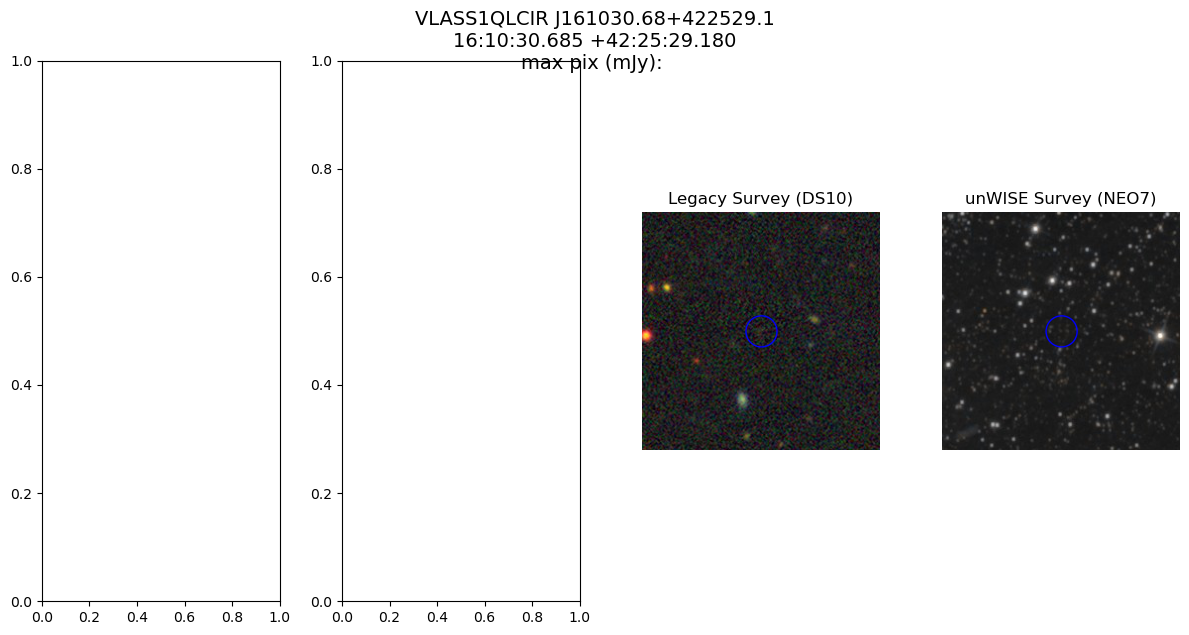

[WARNING] No valid cutouts found for VLASS1QLCIR J161030.68+422529.1. Skipping stats return.
[SKIPPED] VLASS1QLCIR J161030.68+422529.1 — No valid cutouts.


In [11]:
#Generate plots
for i, ra in enumerate(ra_list):
    dec = dec_list[i]
    name = name_list[i]
    images = sorted(image_dict[name]['images'])
    
    try:
        result = make_cutout(ra, dec, unit, images, metadata=metadata,
                             name=name, calculate_stats=True,
                             show=True, save=True,
                             panstarrs=True, verbose=True)
        
        if result is None:
            print(f"[SKIPPED] {name} — No valid cutouts.")
            continue
        
    except Exception as e:
        print(f"[ERROR] {name} — {e}")
        continue